Features to be added!
7/7/23

1. Raw drawing import - scaling
2. Mask cleanup
3. Mask Optimization

In [175]:
#%%
# Created 7/5/2023 by Michael Tan & Josh Green
# Utilized for importing DXF shapes (curated file), generating a mask, than outputting a dxf
# Parsing DXF
import ezdxf as ez
# Maths
import numpy as np
import pandas as pd
# Shapes
import shapely.geometry as spg
from shapely.ops import unary_union, polygonize
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # setting ignore as a parameter and further adding category
import pandas
from descartes import PolygonPatch
from shapely import affinity
# Plotting
import pylab as pl
# Misc
import os
import statistics

# %%
class loaddxf():
    # This is a class object for loading a single DXF file
    def __init__(self,fn,scaledrawing=1):
        # Initialization
        self.fn = fn
        self.dbf = False #debug flag
        self.components = []
        self.cnames = []
        self.scaler = scaledrawing
        
    def loaddrawing(self):
        # Import DXF as a ezdxf object. 
        doc = ez.readfile(self.fn)
        msp = doc.modelspace()
        # Iterate through all items
        for e in msp:
            if self.dbf == True:
                print(e.dxf.layer)
                print(e.dxftype())
            # If we encounter "PKG_OUTLINE" layer, export it to self.pkgout
            if e.dxf.layer == 'PKG_OUTLINE':
                if e.dxftype() == 'LWPOLYLINE':
                    #print(e.vertices(),e.dxftype())
                    p = e.get_points()
                    # update later to add polygon
                    self.pkgout = spg.box(min(p)[0],min(p)[1],max(p)[0],max(p)[1])
                    #print("Package Outline: ")
                    self.pkgout
            # If we encounter Soldermask_pads_btm, export SOLID objects to a list of components
            elif e.dxf.layer == 'SOLDERMASK_PADS_BTM':
                if e.dxftype() == 'SOLID':
                    if self.dbf == True:
                        print(e.dxf.handle)
                        print(e.vertices())
                    self.cnames.append(e.dxf.handle)
                    self.components.append(e.vertices())
        print(str(len(self.components)) + " objects have been found on BSR layer.")
        
    def maptodataframe(self):
        # Using the solid objects encountered, parse into a dataframe or 2.
        P1X,P1Y = [],[]
        P2X,P2Y = [],[]
        P3X,P3Y = [],[]
        P4X,P4Y = [],[]
        CX,CY = [],[]
        for comp in self.components:
            # Identify point# 1 - bottom left corner
            P1X.append(comp[0][0]*self.scaler)
            P1Y.append(comp[0][1]*self.scaler)
            P3X.append(comp[2][0]*self.scaler)
            P3Y.append(comp[2][1]*self.scaler)
            P2X.append(comp[1][0]*self.scaler)
            P2Y.append(comp[1][1]*self.scaler)
            P4X.append(comp[3][0]*self.scaler)
            P4Y.append(comp[3][1]*self.scaler)
        # Sizes
        DX = np.subtract(P3X, P1X)
        DY = np.subtract(P3Y, P1Y)
        # Centers
        CX = np.add(P1X,DX/2)
        CY = np.add(P1Y,DY/2)
        # One DF with centers and corners
        self.df = pd.DataFrame({"CNAME":self.cnames,"X":CX,"Y":CY,"P1X":P1X,"P1Y":P1Y,"P3X":P3X,"P3Y":P3Y})
        # self.dfs = pd.concat([pd.DataFrame({"X":P1X,"Y":P1Y}), pd.DataFrame({"X":P2X,"Y":P2Y}), pd.DataFrame({"X":P3X,"Y":P3Y}),
        #                         pd.DataFrame({"X":P4X,"Y":P4Y})]).reset_index(drop=True)
        # self.dfs = self.dfs.mul(self.poversize)
        print("Completed mapping to dataframes df (center, size, corner points)")

    def maptolistofpoly(self):
        # This is messy for now. We take points than shove it into a box. It would be better to go from dxf vector to polygon.
        # Initialize an empty list
        self.pg_cmp = []
        for index, row in self.df.iterrows():
            p1 = (row.P1X,row.P1Y,row.P3X,row.P3Y)
            poly1 = spg.box(p1[0],p1[1],p1[2],p1[3])
            self.pg_cmp.append(poly1)
        print("pg_cmp is nominal position of all package components.")
            
    def process(self):
        # Load data
        self.loaddrawing()
        # Map to dataframe
        self.maptodataframe()
        # Map to list of BOXES - no oversize. 
        self.maptolistofpoly()
        print("Completed loading all the data")
        
class generatemasks():
    # Class used to generate a mask
    def __init__(self,cmp,exp_cmp=1,exp_out=1.25,squarebound=True):
        # Initialize some variables
        self.dbf = False #debug flag
        self.cmp = cmp
        # Variable to expand components - polygons are extended with a buffer function - magnitude
        self.exp_cmp = exp_cmp
        # Variable to expand outline - simple scaler/multiplier
        self.exp_out = exp_out
        self.squarebound = squarebound
    
    def processcomp(self,expopt=False):
        # Create 3 masks: 
            # cmp_mask: component mask
            # cmp_out: component outline
            # diff_mask: Mask of the difference between outline & mask
        # Combine all smaller polygons & expand with exp_cmp
        if expopt == True:
            for i in np.arange(0.1, 0.8, 0.1):          
                pgroup = [x.buffer(i,8,2).envelope for x in self.cmp]
                cmp_mask = unary_union(pgroup)
                cmp_outline = spg.box(cmp_mask.bounds[0]-self.exp_out,cmp_mask.bounds[1]-self.exp_out,
                    cmp_mask.bounds[2]+self.exp_out,cmp_mask.bounds[3]+self.exp_out)#.buffer(1500)
                self.cmp_mask = cmp_mask
                self.cmp_out = cmp_outline
                # Create a difference mask between outline & smaller polygons
                self.diff_mask = cmp_outline.difference(cmp_mask)
                parea = [x.area for x in self.diff_mask]
                print("Loop at " + str(i))
                print(str(statistics.median(parea)))
                if statistics.median(parea) >=1:
                    print("Minimum small features detected. Buffer = "+str(i))
                    print(str(parea))
                    self.diff_mask = spg.MultiPolygon(list(filter(lambda x: x.area> 1, self.diff_mask)))
                    break

                
        else:
            if (self.squarebound==True):
                pgroup = [x.buffer(self.exp_cmp).envelope.simplify(1) for x in self.cmp]
            else:
                pgroup = [x.buffer(self.exp_cmp).simplify(1) for x in self.cmp]
            cmp_mask = unary_union(pgroup)
            # Create an outline using the cmp_mask X&Y Min/Max values
            cmp_outline = spg.box(cmp_mask.bounds[0]-self.exp_out,cmp_mask.bounds[1]-self.exp_out,
                            cmp_mask.bounds[2]+self.exp_out,cmp_mask.bounds[3]+self.exp_out)#.buffer(1500)
            self.cmp_mask = cmp_mask
            self.cmp_out = cmp_outline
            # Create a difference mask between outline & smaller polygons
            self.diff_mask = cmp_outline.difference(cmp_mask)
            print("created component mask with: Expand = " + str(self.exp_cmp) + " and " + str(self.exp_out) + "x outline.")

        
    def process(self):
        print("Running mask script")
        self.processcomp()
        print("Completed")
               
class plotfun():
    # Function to make plotting just a little easier as I am lazy
    def __init__(self,pg_cmp,diff_poly,fs=(20,10)):
        self.dbf = False #debug flag
        #plotscale= ((pkg_x/pkg_y)*20,(pkg_y/pkg_y)*20)
        self.fs = fs
        self.pg_cmp = pg_cmp
        self.diff_poly = diff_poly
        
    # def plot_polygon(self,data):
    #     # Simple Function to plot polygons
    #     fig = pl.figure(figsize=self.fs)
    #     ax = fig.add_subplot(111)
    #     margin = 1
    #     x_min, y_min, x_max, y_max = data.bounds
    #     ax.set_xlim([x_min-margin, x_max+margin])
    #     ax.set_ylim([y_min-margin, y_max+margin])
    #     patch = PolygonPatch(data, fc='#999999', ec='#000000', fill=True, zorder=-1)
    #     ax.add_patch(patch)
    #     fig = pl.plot(self.x,self.y,'o', color='#f16824')
    #     return fig
    
    # def plot_points(self):
    #     # Simple function to plot points ()
    #     fig = pl.figure(figsize=self.fs)
    #     fig = pl.plot(self.x,self.y,'o', color='#f16824')
    #     return fig
    
    def plot_results(self):
        # Simple function to plot everything together - components & difference mask
        fig = pl.figure(figsize=self.fs)
        ax = fig.add_subplot(111)
        margin = 1
        x_min, y_min, x_max, y_max = self.diff_poly.bounds
        ax.set_xlim([x_min-margin, x_max+margin])
        ax.set_ylim([y_min-margin, y_max+margin])
        patch1 = PolygonPatch(self.diff_poly, fc='green', ec='#000000', fill=True, zorder=-1)
        patch2 = PolygonPatch(unary_union(self.pg_cmp), fc='red', ec='#000000', fill=True, zorder=-1)
        ax.add_patch(patch1)
        ax.add_patch(patch2)
        ax.set_title('Masky mask doing mask things')
        # return fig
    
    # Temp
    # boundary = gpd.GeoSeries(cmp_mask)
    # outline = gpd.GeoSeries(cmp_outline)
    # diff = gpd.GeoSeries(diff_poly)
    
class generatedxf():
    def __init__(self,fn,cmp_mask,diff_mask):
        self.outfile = os.path.splitext(fn)[0]+"_jigstreet.dxf"
        self.cmp_mask = cmp_mask
        self.diff_mask = diff_mask
    
    def addoutline(self):
        for thispoly in self.cmp_mask:
            dt = pd.DataFrame({"X":thispoly.exterior.coords.xy[0], "Y":thispoly.exterior.coords.xy[1]})
            dt['xy'] = dt.apply(lambda x: (x['X'], x['Y']), axis=1)
            self.msp.add_lwpolyline(dt['xy'].tolist())
    
    def addholes(self):
        for thispoly in self.diff_mask:
            dt = pd.DataFrame({"X":thispoly.exterior.coords.xy[0], "Y":thispoly.exterior.coords.xy[1]})
            dt['xy'] = dt.apply(lambda x: (x['X'], x['Y']), axis=1)
            self.msp.add_lwpolyline(dt['xy'].tolist())

    def process(self):
        self.doc = ez.readfile(fn)
        self.msp = self.doc.modelspace()
        self.doc.layers.new("JIG_STREET")
        self.addoutline()
        self.addholes()
        self.doc.saveas(self.outfile)
        print("Saved "+ str(self.outfile))   
#%%
# if __name__ == "__main__":
#     # Main script to run
#     fn = r"E:\Scripting\MACD\MACD\TCB\Examples\M55024-001_BSR_r01.dxf"
#     # fn = r"E:\Scripting\dxf\M86710-001_BSR_Cleaned Up.dxf"
#     # fn = r"E:\Scripting\dxf\input_example.dxf"
#     rawdxf = loaddxf(fn)
#     rawdxf.process()
#     cmp_koz = 0.5 # Scaler
#     group_koz = 1 # Adder
#     masks = generatemasks(rawdxf.pg_cmp,cmp_koz,group_koz)
#     masks.process()
#     plots = plotfun(rawdxf.pg_cmp,masks.diff_mask) 
#     plots.plot_results() # We input raw positions & generated masks into a plot together
#     # %%
#     woof = generatedxf(fn,masks.cmp_mask,masks.diff_mask)
#     woof.process()

 # %%
 


In [176]:
def processdxf(dxf,cmp_koz=0.5):
    dxffile = os.path.join(root,"Examples",dxf)
    print("File to process: " + dxffile)
    rawdxf = loaddxf(dxffile,scaledrawing=0.01)
    rawdxf.process()
    # cmp_koz = 0.35 # Scaler (POR is ~350 from speed or ~0.35 for scaled)
    group_koz = cmp_koz # OutlineAdder
    squarebound = True
    masks = generatemasks(rawdxf.pg_cmp,cmp_koz,group_koz,squarebound)
    masks.process()
    plots = plotfun(rawdxf.pg_cmp,masks.diff_mask) 
    plots.plot_results() # We input raw positions & generated masks into a plot together
    return ("Processed.")

In [178]:
    def loaddrawing(self):
        # Import DXF as a ezdxf object. 
        doc = ez.readfile(self.fn)
        msp = doc.modelspace()
        # Iterate through all items
        for e in msp:
            if self.dbf == True:
                print(e.dxf.layer)
                print(e.dxftype())
            # If we encounter "PKG_OUTLINE" layer, export it to self.pkgout
            if e.dxf.layer == 'PKG_OUTLINE':
                if e.dxftype() == 'LWPOLYLINE':
                    #print(e.vertices(),e.dxftype())
                    p = e.get_points()
                    # update later to add polygon
                    self.pkgout = spg.box(min(p)[0],min(p)[1],max(p)[0],max(p)[1])
                    #print("Package Outline: ")
                    self.pkg_x = max(self.pkgout.boundary.coords.xy[0])-min(self.pkgout.boundary.coords.xy[0])
                    self.pkg_y = max(self.pkgout.boundary.coords.xy[1])-min(self.pkgout.boundary.coords.xy[1])
            # If we encounter Soldermask_pads_btm, export SOLID objects to a list of components
            elif e.dxf.layer == 'SOLDERMASK_PADS_BTM':
                if e.dxftype() == 'SOLID':
                    if self.dbf == True:
                        print(e.dxf.handle)
                        print(e.vertices())
                    self.cnames.append(e.dxf.handle)
                    self.components.append(e.vertices())
        print(str(len(self.components)) + " objects have been found on BSR layer.")

In [132]:
fn = os.path.join(root,"Examples",dxf)
doc = ez.readfile(fn)
msp = doc.modelspace()

In [146]:
for e in msp:
    if e.dxf.layer == 'PKG_OUTLINE':
        print(e.dxf.layer)
        print(e.dxftype())
        p = e.get_points()
        pkgout = spg.box(min(p)[0],min(p)[1],max(p)[0],max(p)[1])

PKG_OUTLINE
LWPOLYLINE


In [180]:
for e in msp:
    # If we encounter "PKG_OUTLINE" layer, export it to self.pkgout
    if e.dxf.layer == 'PKG_OUTLINE':
        if e.dxftype() == 'LWPOLYLINE':
            #print(e.vertices(),e.dxftype())
            p = e.get_points()
            # update later to add polygon
            self.pkgout = spg.box(min(p)[0],min(p)[1],max(p)[0],max(p)[1])
            #print("Package Outline: ")
            self.pkg_x = max(self.pkgout.boundary.coords.xy[0])-min(self.pkgout.boundary.coords.xy[0])
            self.pkg_y = max(self.pkgout.boundary.coords.xy[1])-min(self.pkgout.boundary.coords.xy[1])
    # If we encounter Soldermask_pads_btm, export SOLID objects to a list of components
    elif e.dxf.layer == 'SOLDERMASK_PADS_BTM':
        if e.dxftype() == 'SOLID':
            if self.dbf == True:
                print(e.dxf.handle)
                print(e.vertices())
            self.cnames.append(e.dxf.handle)
            self.components.append(e.vertices())
print(str(len(self.components)) + " objects have been found on BSR layer.")

NameError: name 'self' is not defined

In [163]:
pkg_x = max(pkgout.boundary.coords.xy[0])-min(pkgout.boundary.coords.xy[0])
pkg_y = max(pkgout.boundary.coords.xy[1])-min(pkgout.boundary.coords.xy[1])


In [164]:
plotscale = (20,10)

In [171]:
(pkg_x/pkg_y)*20

10.0

In [174]:
plotscale= ((pkg_x/pkg_y)*20,(pkg_y/pkg_y)*20)

In [172]:
(pkg_y/pkg_y)*20

20.0

In [158]:
min(pkgout.boundary.coords.xy[0])

-12500.0

In [137]:
rawdxf = loaddxf(os.path.join(root,"Examples",dxf),scaledrawing=0.01)


File to process: E:\Scripting\MACD\MACD\TCB\Examples\M25268-001_BSR_LLT_r02.dxf
448 objects have been found on BSR layer.
Completed mapping to dataframes df (center, size, corner points)
pg_cmp is nominal position of all package components.
Completed loading all the data
Running mask script
created component mask with: Expand = 3 and 3x outline.
Completed
File to process: E:\Scripting\MACD\MACD\TCB\Examples\M37813-001_BSR_r01 ww22.dxf
184 objects have been found on BSR layer.
Completed mapping to dataframes df (center, size, corner points)
pg_cmp is nominal position of all package components.
Completed loading all the data
Running mask script
created component mask with: Expand = 3 and 3x outline.
Completed
File to process: E:\Scripting\MACD\MACD\TCB\Examples\M54481-001_BSR_r01.dxf
92 objects have been found on BSR layer.
Completed mapping to dataframes df (center, size, corner points)
pg_cmp is nominal position of all package components.
Completed loading all the data
Running mask scr

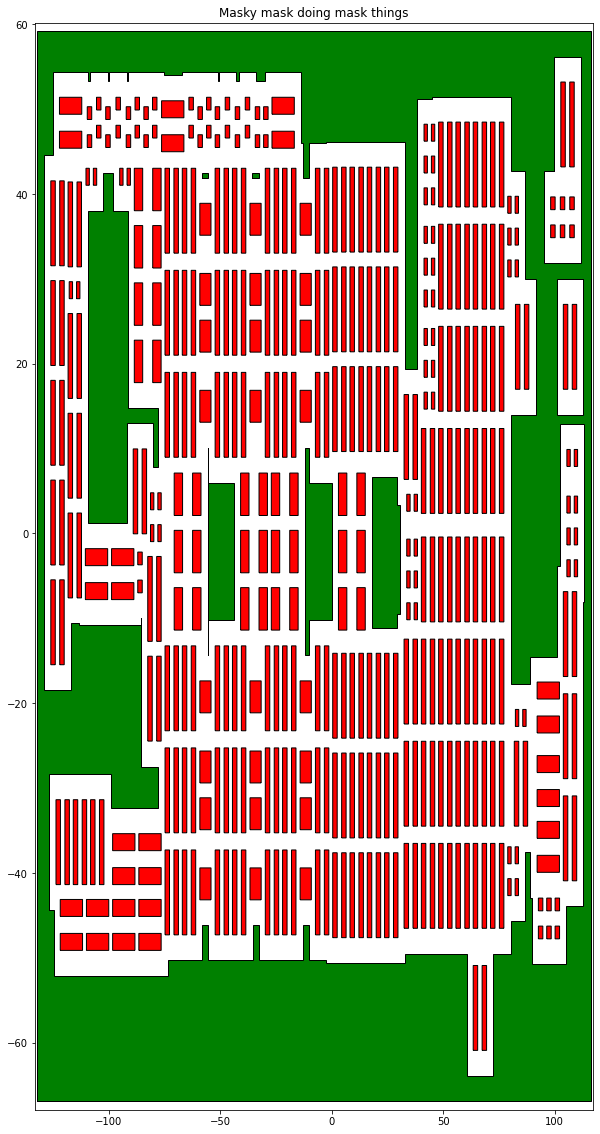

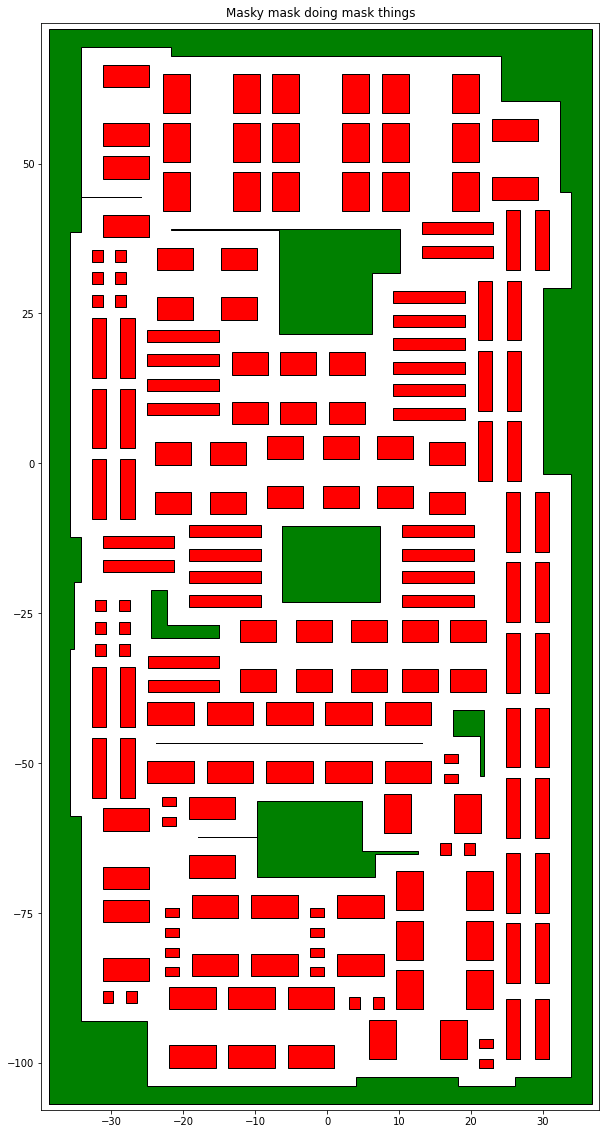

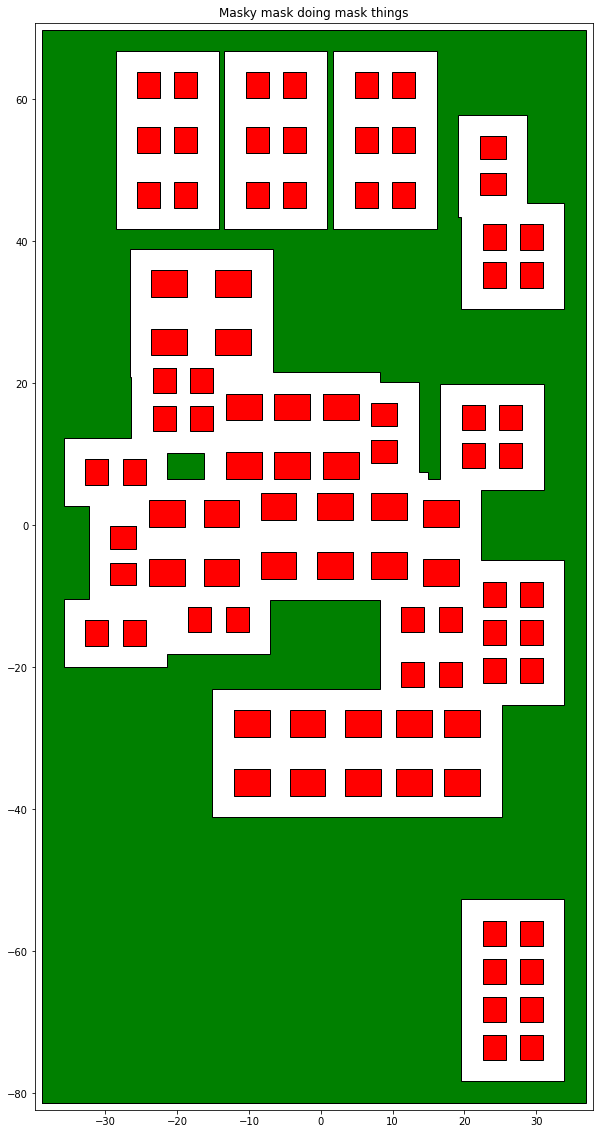

In [177]:
# Search the folder for 
root = r"E:\Scripting\MACD\MACD\TCB"
dxfs = os.listdir(os.path.join(root,"Examples"))
for dxf in dxfs[:3]:
    processdxf(dxf,3)


Package Outline: 
184 objects have been found on BSR layer.
Completed mapping to dataframes df (center, size, corner points)
Completed loading all the data
Running mask script
created component mask with: Expand = 375 and 375x outline.
Completed


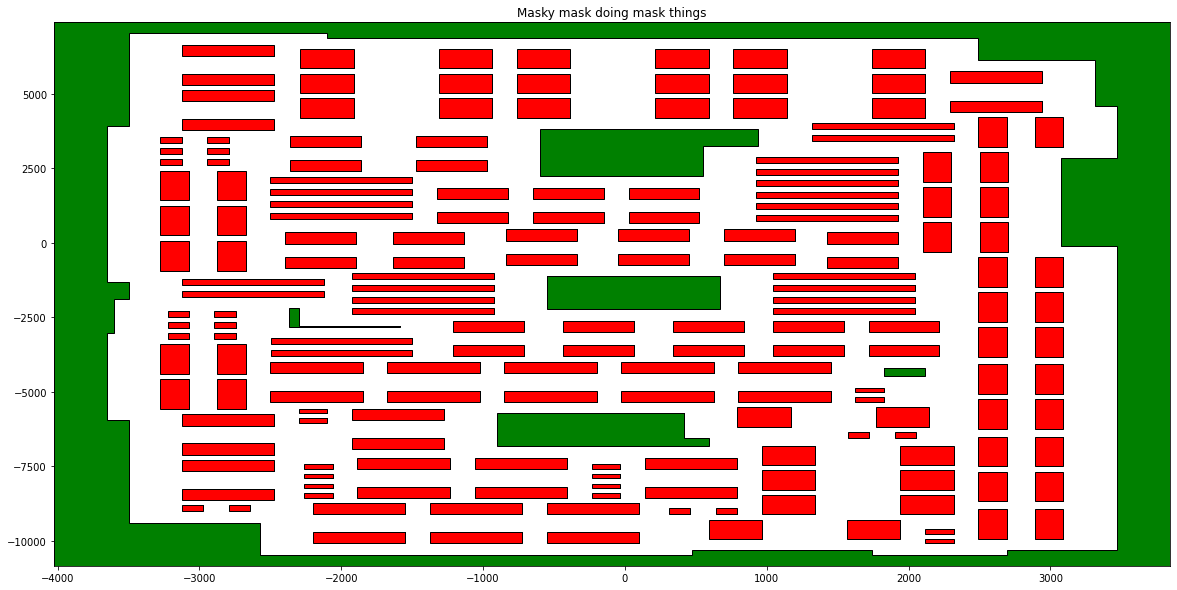

In [83]:
# fn = r"E:\Scripting\MACD\MACD\TCB\Examples\M37813-001_BSR_r01 ww22.dxf"
# fn = r"E:\Scripting\dxf\M86710-001_BSR_Cleaned Up.dxf"
# fn = r"E:\Scripting\dxf\input_example.dxf"
rawdxf = loaddxf(fn)
rawdxf.process()
cmp_koz = 375 # Scaler
group_koz = 375 # OutlineAdder
squarebound = True
masks = generatemasks(rawdxf.pg_cmp,cmp_koz,group_koz,squarebound)
masks.process()
plots = plotfun(rawdxf.pg_cmp,masks.diff_mask) 
plots.plot_results() # We input raw positions & generated masks into a plot together

Package Outline: 
220 objects have been found on BSR layer.
Completed mapping to dataframes df
Completed loading all the data
Running mask script
created component mask with: Expand = 375 and 375x outline.
Completed


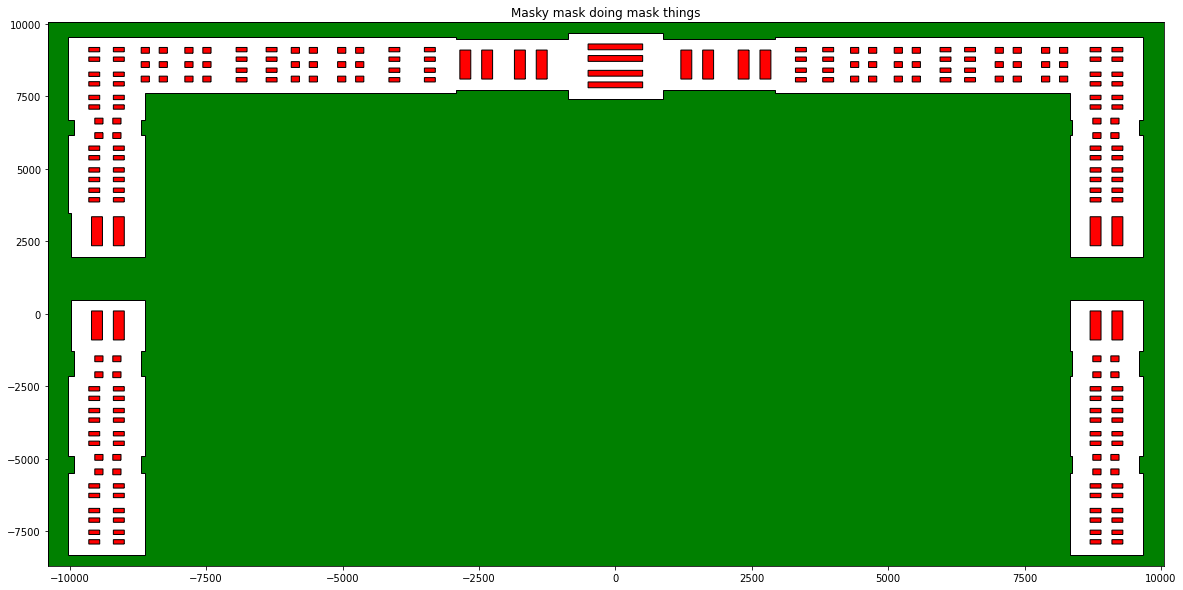

In [72]:
fn = r"E:\Scripting\MACD\MACD\TCB\Examples\M55024-001_BSR_r01.dxf"
# fn = r"E:\Scripting\dxf\M86710-001_BSR_Cleaned Up.dxf"
# fn = r"E:\Scripting\dxf\input_example.dxf"
rawdxf = loaddxf(fn)
rawdxf.process()
cmp_koz = 375 # Scaler
group_koz = 375 # OutlineAdder
masks = generatemasks(rawdxf.pg_cmp,cmp_koz,group_koz)
masks.process()
plots = plotfun(rawdxf.pg_cmp,masks.diff_mask) 
plots.plot_results() # We input raw positions & generated masks into a plot together


Package Outline: 
220 objects have been found on BSR layer.
Completed mapping to dataframes df
Completed loading all the data


In [39]:

cmp_koz = 0.5 # Scaler
group_koz = 1 # Adder
masks = generatemasks(rawdxf.pg_cmp,cmp_koz,group_koz)
masks.process()

Running mask script
created component mask with: Expand = 0.5 and 1x outline.
Completed


c:\Users\mtan\AppData\Local\Programs\Python\Python36\lib\site-packages\descartes\patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
c:\Users\mtan\AppData\Local\Programs\Python\Python36\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
c:\Users\mtan\AppData\Local\Programs\Python\Python36\lib\site-packages\descartes\patch.py:46: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  polygon = [Polygon(p) for p in polygon]


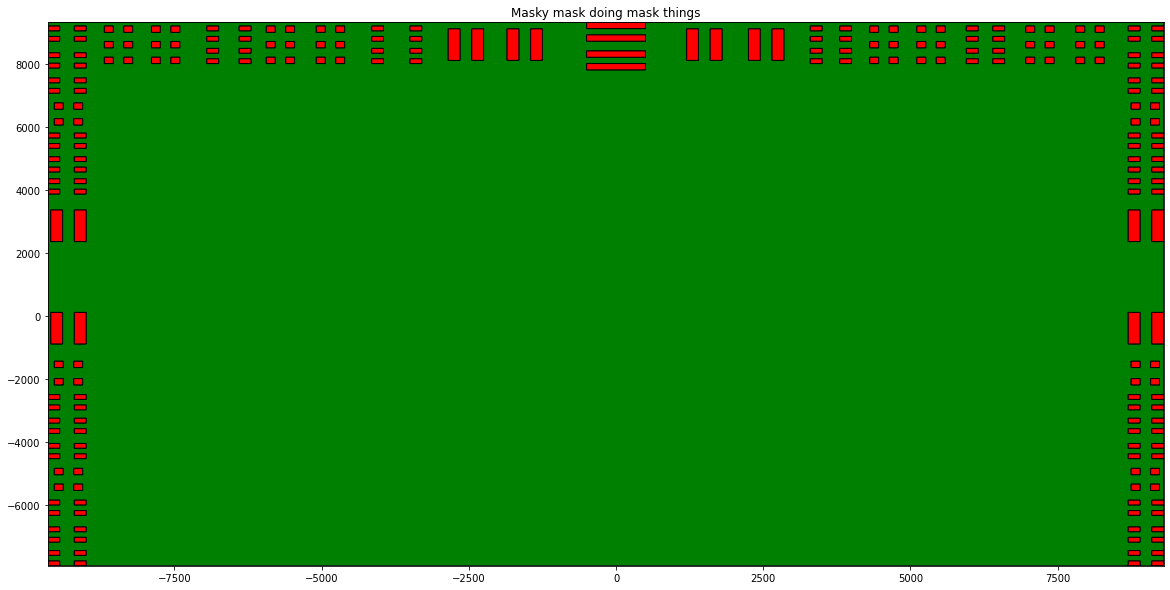

In [46]:
plots = plotfun(rawdxf.pg_cmp,masks.diff_mask) 
plots.plot_results() # We input raw positions & generated masks into a plot together

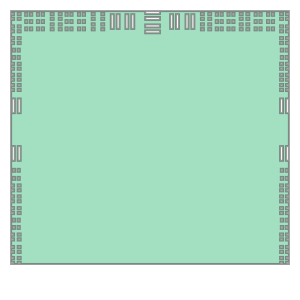

In [56]:
masks.diff_mask

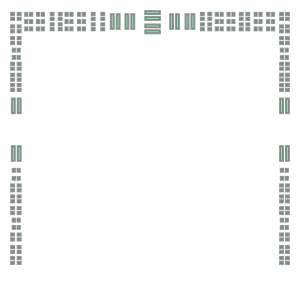

In [57]:
masks.cmp_mask

Running mask script
created component mask with: Expand = 375 and 375x outline.
Completed


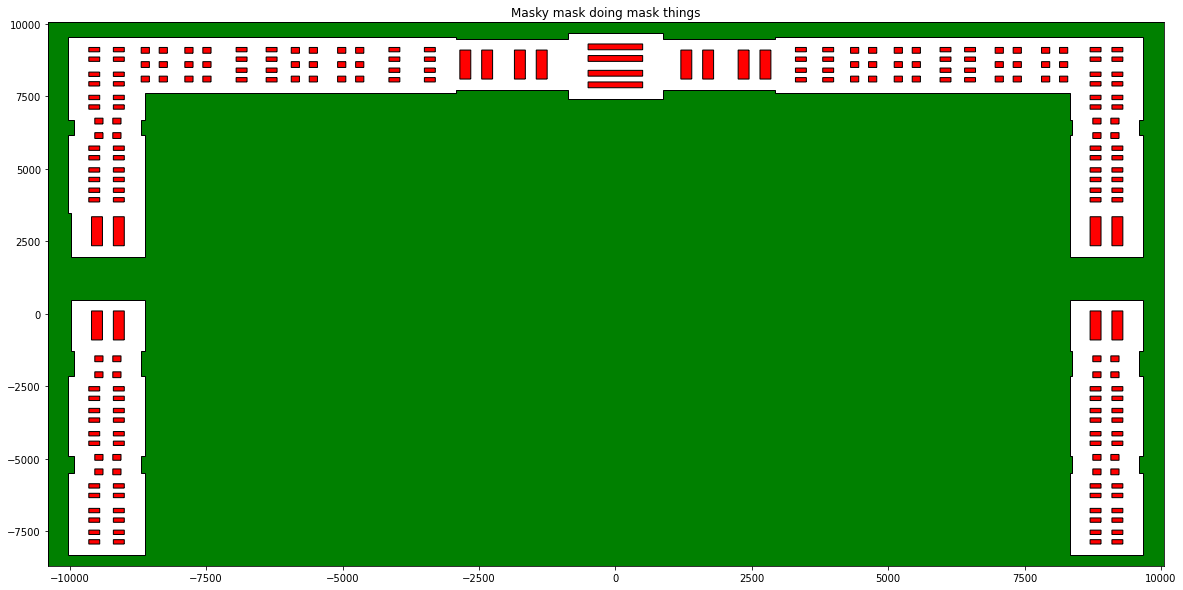

In [71]:
cmp_koz = 375 # Scaler
group_koz = 375 # OutlineAdder
masks = generatemasks(rawdxf.pg_cmp,cmp_koz,group_koz)
masks.process()
plots = plotfun(rawdxf.pg_cmp,masks.diff_mask) 
plots.plot_results() # We input raw positions & generated masks into a plot together